### load data & transformation

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle          
import seaborn as sns

In [3]:
df = pd.read_csv('heloc_dataset_v1.csv')

In [4]:
n_rows = df.shape[0]
n_cols = df.shape[1]
col_names = list(df.columns)
row_indexes = list(df.index)

In [5]:
cols_numeric = []
cols_string = []

for colname in col_names:
    if df[colname].dtypes == 'object':
        cols_string.append(colname)
    if df[colname].dtypes in ['int64', 'float64']:
        cols_numeric.append(colname)

In [6]:
df_missing_ExternalRiskEstimate = df.loc[df["ExternalRiskEstimate"] == -9,:]
n_rows_with_missing_ExternalRiskEstimate = df_missing_ExternalRiskEstimate.shape[0]

n_rows_all_numeric_missing = (df_missing_ExternalRiskEstimate.loc[:,cols_numeric]==-9).sum(axis=0).min()

df_without_missing_rows = df.loc[df.index[(df.loc[:,cols_numeric]==-9).sum(axis=1) != 23],:]

In [7]:
df = df_without_missing_rows

In [8]:
X = df.iloc[:,1:25]
Y = df['RiskPerformance'].map(dict(Bad = 1, Good = 0))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1234)
Y_train, Y_test  = train_test_split(Y, test_size=0.2, random_state=1234)

In [10]:
df_train = pd.concat([X_train, Y_train], axis = 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1234)
Y_train, Y_test  = train_test_split(Y, test_size=0.2, random_state=1234)

In [12]:
# index_selected = X_train[X_train['ExternalRiskEstimate'] != -9].index().tolist()
X_train = X_train[df['ExternalRiskEstimate'] != -9]
X_test = X_test[df['ExternalRiskEstimate'] != -9]
Y_train = Y_train[Y_train.index.isin(X_train.index)]
Y_test = Y_test[Y_test.index.isin(X_test.index)]

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df_count_missing = pd.concat([(X_train==-7).sum(), (X_train==-8).sum(), (X_train==-9).sum()], axis=1)
df_count_missing.columns = [-7,-8,-9]
df_count_missing

,-7,-8,-9
ExternalRiskEstimate,0,0,0
MSinceOldestTradeOpen,0,199,0
MSinceMostRecentTradeOpen,0,0,0
AverageMInFile,0,0,0
NumSatisfactoryTrades,0,0,0
NumTrades60Ever2DerogPubRec,0,0,0
NumTrades90Ever2DerogPubRec,0,0,0
PercentTradesNeverDelq,0,0,0
MSinceMostRecentDelq,3727,130,0
MaxDelq2PublicRecLast12M,0,0,0


In [14]:
from sklearn.impute import MissingIndicator
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

minus_7_indicator_transformer = MissingIndicator(missing_values=-7, 
                                                 features='missing-only').fit(X_train)
minus_8_indicator_transformer = MissingIndicator(missing_values=-8, 
                                                 features='missing-only').fit(X_train)

arr7_X_train_t = minus_7_indicator_transformer.transform(X_train)
arr8_X_train_t = minus_8_indicator_transformer.transform(X_train)

do_nothing_imputer = ColumnTransformer([("Imputer -7 to mean", SimpleImputer(missing_values=-7, strategy='mean'), [])], remainder='passthrough')

feature_expansion = FeatureUnion([("do nothing", do_nothing_imputer),
                                  ("add features for -7", MissingIndicator(missing_values=-7, features='missing-only')),
                                  ("add features for -8", MissingIndicator(missing_values=-8, features='missing-only'))])

# pipeline = "replace this string with your answer" 
pipeline = Pipeline([("expand features", feature_expansion), 
                 ("replace -7 with -8", SimpleImputer(missing_values=-7, strategy='constant', fill_value=-8)),
                 ("replace -8 with mean", SimpleImputer(missing_values=-8, strategy='mean'))])

arr_X_train_t = pipeline.fit_transform(X_train)

col_names_minus_7 = X_train.columns.values[minus_7_indicator_transformer.features_].tolist() 
col_names_minus_7 = list(map(lambda s:str(s)+'=-7',col_names_minus_7)) 
col_names_minus_8 = X_train.columns.values[minus_8_indicator_transformer.features_].tolist() 
col_names_minus_8 = list(map(lambda s:str(s)+'=-8',col_names_minus_8))
column_names = X_train.columns.values.tolist() + col_names_minus_7 + col_names_minus_8
# column_names == ANSWER_KEY['column_names']

In [15]:
X_train_t = pd.DataFrame(arr_X_train_t, columns=column_names)

X_test_t = pipeline.transform(X_test)
X_test_t = pd.DataFrame(X_test_t, columns=column_names)
X_test_t

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days=-7,MSinceOldestTradeOpen=-8,MSinceMostRecentDelq=-8,MSinceMostRecentInqexcl7days=-8,NetFractionRevolvingBurden=-8,NetFractionInstallBurden=-8,NumRevolvingTradesWBalance=-8,NumInstallTradesWBalance=-8,NumBank2NatlTradesWHighUtilization=-8,PercentTradesWBalance=-8
0,70.0,206.0,3.0,96.0,18.0,3.0,0.0,59.0,11.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,42.0,179.0,1.0,72.0,50.0,9.0,6.0,69.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74.0,219.0,3.0,90.0,42.0,0.0,0.0,96.0,6.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.0,445.0,15.0,125.0,12.0,0.0,0.0,83.0,21.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,88.0,320.0,4.0,93.0,52.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,89.0,274.0,11.0,125.0,15.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969,77.0,112.0,15.0,67.0,12.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1970,70.0,366.0,9.0,163.0,17.0,2.0,2.0,74.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1971,57.0,239.0,2.0,93.0,28.0,0.0,0.0,93.0,3.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
len(list(X_test_t.columns))

34

### Model Training

In [17]:
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [18]:
X_train_t_tr, X_train_t_val = train_test_split(X_train_t, test_size=0.25, random_state=1111)
Y_train_t_tr, Y_train_t_val = train_test_split(Y_train, test_size=0.25, random_state=1111)

training

In [19]:
clf_log_reg = linear_model.LogisticRegression(C=2.212216291070449, max_iter=10000,solver='liblinear').fit(X_train_t_tr, Y_train_t_tr) 
accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val))
# print('Logistic regression accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))

0.7489858012170385

In [20]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_train_t_val, clf_log_reg.predict(X_train_t_val))

In [21]:
conf_matrix

array([[689, 261],
       [234, 788]])

### Risk score plot

In [22]:
log_reg_coefficients = np.append(clf_log_reg.coef_, clf_log_reg.intercept_)

In [23]:
log_reg_coefficients

array([-3.53678745e-02, -2.27599821e-04,  7.26148977e-03, -9.16206905e-03,
       -2.97568779e-02,  7.26980325e-02,  1.91643318e-02, -9.05181723e-03,
       -8.86938343e-03, -5.68631637e-02,  5.04109690e-02, -1.53515900e-03,
        1.47105960e-02,  7.39073623e-03, -5.28907409e-02,  4.04853892e-01,
       -3.45854459e-01,  1.16829380e-02,  3.30869176e-03,  9.25539644e-02,
       -6.30070332e-03,  7.21658764e-02, -2.84812540e-03, -4.63516625e-01,
        3.65475839e-01,  1.20906456e-01,  3.04508626e-01, -9.84095195e-01,
       -1.39973528e-02,  3.75452838e-02, -5.96324419e-02,  6.97259779e-02,
        7.12328632e-01, -1.79626541e+00,  3.98167621e+00])

In [24]:
clf_log_reg.intercept_

array([3.98167621])

将input转为dataframe， 赋值给obsToPredict。或者可以直接用output（在判断大小前的value）赋值给valuePredicted。

In [22]:
obsToPredict = X_train_t_val.iloc[:1,:]

In [23]:
obsToPredict

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days=-7,MSinceOldestTradeOpen=-8,MSinceMostRecentDelq=-8,MSinceMostRecentInqexcl7days=-8,NetFractionRevolvingBurden=-8,NetFractionInstallBurden=-8,NumRevolvingTradesWBalance=-8,NumInstallTradesWBalance=-8,NumBank2NatlTradesWHighUtilization=-8,PercentTradesWBalance=-8
1389,61.0,131.0,1.0,44.0,9.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:

valuePredicted = float((np.dot(obsToPredict, log_reg_coefficients[:-1]) + log_reg_coefficients[-1])[0])

In [25]:
valuePredicted

2.111492786427242

In [26]:
riskScore = 1/(1+np.exp(-1*valuePredicted))
riskScore

0.8920152086799791

In [27]:
## plot
from scipy.special import expit
scorePlot = pd.DataFrame(columns = ("Overall Risk", "Risk Score Estimated"))

riskRange = np.arange(-6, 6, 0.01).tolist()

for i in range(0, len(riskRange)):
    newrow = [riskRange[i], expit(riskRange[i])]
    scorePlot.loc[i] = newrow

In [28]:
scorePlot.head()

,Overall Risk,Risk Score Estimated
0,-6.00,0.002473
1,-5.99,0.002497
2,-5.98,0.002522
3,-5.97,0.002548
4,-5.96,0.002573


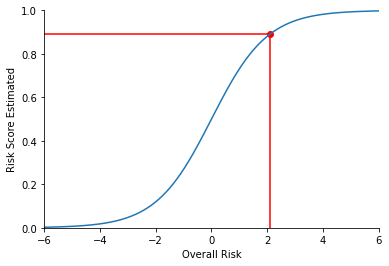

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.lineplot(data=scorePlot, x = "Overall Risk", y = "Risk Score Estimated")
ax.scatter(valuePredicted, riskScore, color = "red")
ax.hlines(riskScore, xmin = -6, xmax = valuePredicted, color = "red")
ax.vlines(valuePredicted, ymin = 0, ymax = riskScore, color = "red")
# ax.hlines(y=0.2, xmin=4, xmax=20, linewidth=2, color='r')
# ax.axvline(valuePredicted, ymin = 0, ymax = riskScore, color = "red")
plt.xlim([-6,6])
plt.ylim([0,1])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

### cross validation

In [30]:
clf_log_reg = linear_model.LogisticRegression(max_iter=10000).fit(X_train_t_tr, Y_train_t_tr) 

In [31]:
import pickle
with open("clf_log_reg_model.p","wb") as f:
    pickle.dump("clf_log_reg_model.p", f)

In [32]:
cv_results_log_reg = cross_validate(linear_model.LogisticRegression(C=2.212216291070449, max_iter=10000,solver='liblinear'), X_train_t, Y_train, cv=5, return_estimator=True)

NameError: name 'cross_validate' is not defined

In [ ]:
cv_results_log_reg

In [ ]:
cv_results_log_reg['test_score']

In [ ]:
print('Logistic regresion - CV accuracy score %.3f'%cv_results_log_reg['test_score'].mean()) # this is their average

In [ ]:
print('Logistic regresion - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))